In [56]:
from __future__ import print_function
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

try:
    from scipy.special import comb as _comb
except ImportError:
    def _comb(n, k):
        return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))

# Boils down to "If I pick nodes (rf - 1) * vnode times, how many
# distinct nodes will I have in expectation. Note that this is a slightly
# optimistic estimate because Cassandra won't place two replicas of the
# same token on the same machine or rack, but this is close enough for
# the model
# https://math.stackexchange.com/questions/72223/
# finding-expected-number-of-distinct-values-selected-from-a-set-of-integers
def num_neighbors(n, v, rf):
    k = v * (rf - 1)
    # As cassandra is rack aware, we assume #racks == #replicas
    # This is maybe a bad assumption for some datacenter deployments
    n = n - (n / rf)
    estimate = sum((-1)**i * _comb(k, i + 1, exact=True) * n**(-i) for i in range(0, k-1))
    return max(rf - 1, min(estimate, n))

def p_outage_given_failure(recovery, num_neighbors, rate):
    x =  math.exp(-1 * recovery * num_neighbors * rate)
    return 1 - x

def exp_failures(num_nodes, rate, year):
    return num_nodes * rate * year

def recovery_c(size, bw_in, bw_out, neighbors):
    return int(size / (min(bw_in, neighbors * bw_out)))

num_nodes = 96
vnodes = 256
rf = 3
# 1000 gigabytes
node_dataset_mb = 300 * 1024
# MB/s
bw_in = 125
bw_out = 25

year = 60.0*60*24*365
arate = 0.25 / year


print("\nFailure Rate Variability")
neighbors = num_neighbors(num_nodes, vnodes, rf)
print("Neighbors for {0} vnodes: {1}".format(vnodes, neighbors))
recovery = recovery_c(node_dataset_mb, bw_in, bw_out, neighbors)

for i in (0.125, 0.25, 0.5, 1, 2):
    rate = i / (year)
    failures = exp_failures(num_nodes, rate, year)
    probability = p_outage_given_failure(recovery, neighbors, rate)

    p = "{0:.3f} {1:.2f} {2:.6f} {3:.6f}".format(
        i, failures, probability, failures * probability
    )
    print(p)


def compute_outage(vnodes, failure_rate, num_nodes, rf, bw_in, bw_out):
    neighbors = num_neighbors(num_nodes, vnodes, rf)
    recovery = recovery_c(node_dataset_mb, bw_in, bw_out, neighbors)
    failures = exp_failures(num_nodes, failure_rate, year)
    probability = p_outage_given_failure(recovery, neighbors, failure_rate)
    #p = "{0} {1:.2f} {2:.6f} {3:.6f}".format(
    #    vnodes, neighbors, probability, failures * probability
    #)
    #if vnodes < 32 or vnodes > 255:
    #    print(p)
    return failures * probability



Failure Rate Variability
Neighbors for 256 vnodes: 63.9798444518
0.125 12.00 0.000623 0.007475
0.250 24.00 0.001245 0.029890
0.500 48.00 0.002489 0.119485
1.000 96.00 0.004972 0.477343
2.000 192.00 0.009920 1.904627


[0.0005844606522886764, 0.000584285637624582, 0.000674353101482339]
[0.0023377856767785588, 0.002337085652212245, 0.002697336613911361]
[0.005259889679066099, 0.005258314700494537, 0.006068836855650961]
[0.00935068727029531, 0.009347887444734582, 0.010788740153580889]


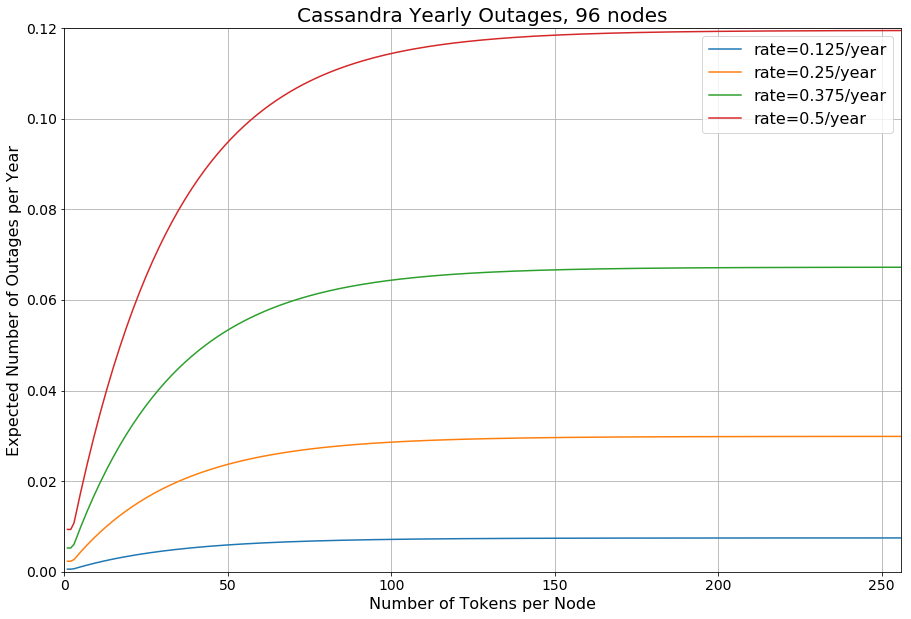

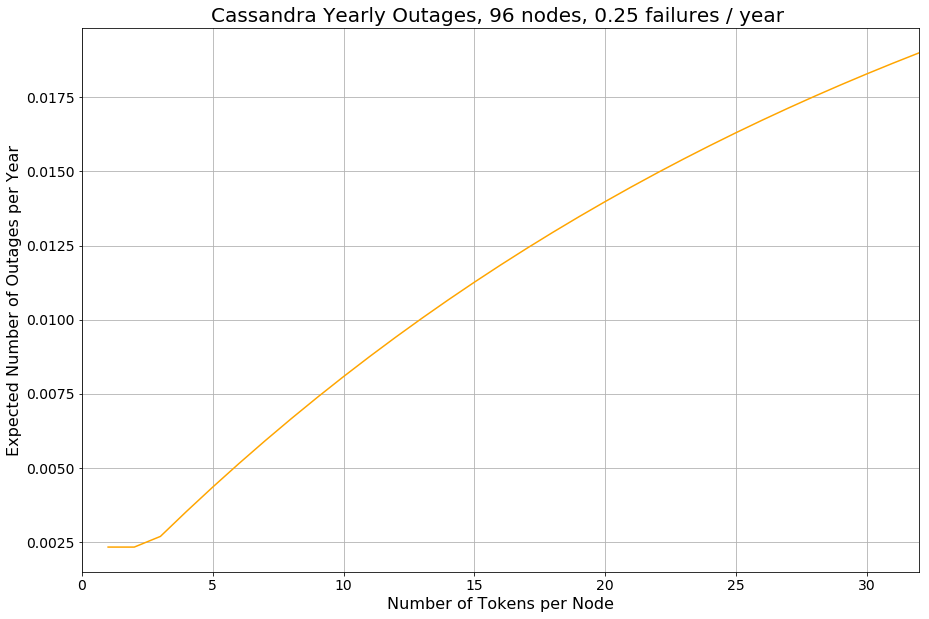

In [57]:
plt.figure(figsize=(15,10))
plt.title("Cassandra Yearly Outages, {0} nodes".format(num_nodes, arate * year), fontsize=20)
plt.ylabel("Expected Number of Outages per Year", fontsize=16)
plt.xlabel("Number of Tokens per Node", fontsize=16)
plt.xlim(0, 256)
plt.ylim(0, 0.12)
plt.gca().grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)

num_vnodes = range(1, 257)
rates = [x / year for x in (0.125, 0.250, 0.375, 0.5)]
for rate in rates:
    outages = []
    for vnode in num_vnodes:
        outages.append(compute_outage(vnode, rate, num_nodes, rf, bw_in, bw_out))
    print(outages[:3])
    plt.plot(num_vnodes, outages, label="rate={0}/year".format(rate*year))
plt.legend(fontsize=16)

outages = [compute_outage(vnodes, arate, num_nodes, rf, bw_in, bw_out) for vnodes in num_vnodes]
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Yearly Outages, {0} nodes, {1:.2f} failures / year ".format(
        num_nodes, arate * year), fontsize=20)
plt.ylabel("Expected Number of Outages per Year", fontsize=16)
plt.xlabel("Number of Tokens per Node", fontsize=16)
plt.xlim(0, 32)
plt.gca().grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot(num_vnodes[:32], outages[:32], color='orange')

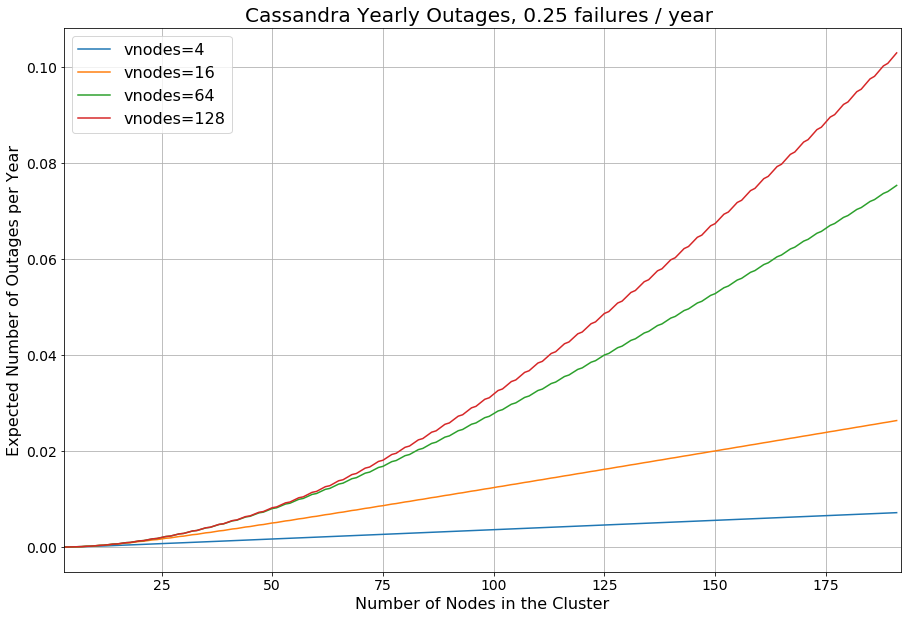

In [61]:
# Hold vnodes constant, vary size of cluster
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Yearly Outages, {1:.2f} failures / year ".format(
        vnodes, arate * year), fontsize=20)
plt.ylabel("Expected Number of Outages per Year", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)

num_vnodes = (4, 16, 64, 128)
num_nodes = range(3, 192)
for vnodes in num_vnodes:
    outages = [compute_outage(vnodes, arate, nodes, rf, bw_in, bw_out) for nodes in num_nodes]
    plt.plot(num_nodes, outages, label="vnodes={0}".format(vnodes))

plt.xlim(3, 192)
plt.legend(fontsize=16)